$$
P(y \mid X) = \frac{P(X \mid y)P(y)}{P(X)} 
$$

* $X \in \mathbb{R}^{n}$ refers to a single instance with $n$ instances
* $y$ is the corresponding label for that instance.

Specifically,

$$
X = \left(x_{1}, x_{2}, \dots, x_{n} \right)^{T} 
$$

Naive Bayes can be represented as

$$
P(y \mid x_{1} \dots x_{n}) = \frac{P(x_{1} \mid y) \dots P(x_{n} \mid y)P(y)}{P(x_{1}) \dots P(x_{n})} 
$$

The dominator is known as the evidence in bayesian inference, and is a normalising factor to make sure that the posterior distribution integrates to 1. As such

$$
P(y \mid x_{1} \dots x_{n}) \propto P(y) \prod_{i=1}^{n} P(x_{i} \mid y) 
$$

This is maximum a posteriori estimation. We want to maximise the posterior distribution for each training instance

$$
\hat{y} = \underset{y}{\arg \max} \; P(y) \prod_{i=1}^{n} P(x_{i} \mid y)
$$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
plt.style.use('seaborn')
np.random.seed(123)

#https://jaketae.github.io/study/naive-bayes/

In [2]:
dataset = np.array([[2.7810836,2.550537003],
           [1.465489372,2.362125076],
           [3.396561688,4.400293529],
           [1.38807019,1.850220317],
           [3.06407232,3.005305973],
           [7.627531214,2.759262235],
           [5.332441248,2.088626775],
           [6.922596716,1.77106367],
           [8.675418651,-0.242068655],
           [7.673756466,3.508563011]])
label = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [3]:
def separate_by_class(X, y):
    class_dict ={}
    for i, label in enumerate(y):
        if label in class_dict:
            class_dict[label].append(i)
        else:
            class_dict[label] = [i]
    for k, v in class_dict.items():
        class_dict[k] = X[v]
    return class_dict

In [4]:
class_dict = separate_by_class(dataset, label)
class_dict

{0: array([[2.7810836 , 2.550537  ],
        [1.46548937, 2.36212508],
        [3.39656169, 4.40029353],
        [1.38807019, 1.85022032],
        [3.06407232, 3.00530597]]),
 1: array([[ 7.62753121,  2.75926224],
        [ 5.33244125,  2.08862677],
        [ 6.92259672,  1.77106367],
        [ 8.67541865, -0.24206865],
        [ 7.67375647,  3.50856301]])}

In [5]:
def summarizer(data):
    summary = [[np.mean(column), np.std(column)] for column in zip(*data)]
    return summary

summarizer(dataset)

[[4.8327021465, 2.6051838419314794], [2.4053928934, 1.1629554833322375]]

In [6]:
def summarize_by_class(class_dict):
    summary_dict = {}
    for k, v in class_dict.items():
        summary_dict[k] = summarizer(v)
    return summary_dict

In [7]:
summarize_by_class(class_dict)

{0: [[2.4190554339999997, 0.833648422388659],
  [2.8336963796, 0.8664248811868022]],
 1: [[7.246348858999999, 1.1079779342778044],
  [1.9770894072, 1.2599012203753612]]}

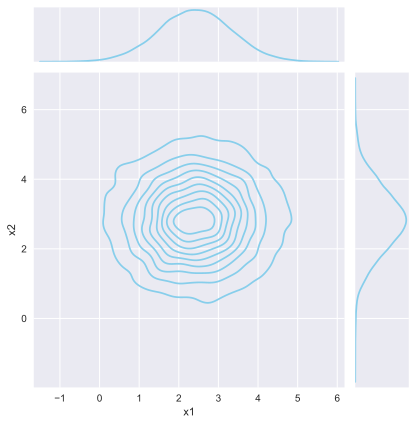

In [8]:
x1, x2 = np.random.RandomState(8).multivariate_normal([2.4190554339999997, 2.8336963796], [(0.833648422388659, 0), (0, 0.8664248811868022)], 10000).T
df = pd.DataFrame({"x1":x1,"x2":x2})
sns.jointplot(data=df, x='x1', y='x2', kind='kde', color='skyblue')
plt.show()

In [9]:
def prior(class_dict, y):
    prior_dict = {}
    total_num = len(y)
    for k, v in class_dict.items():
        prior_dict[k] = len(v)/total_num
    return prior_dict

In [10]:
prior(class_dict, label)

{0: 0.5, 1: 0.5}

In [11]:
def likelihood(class_dict, test_instance):
    likelihood_dict = {}
    feature_summary = summarize_by_class(class_dict)
    for k in feature_summary.keys():
        value = feature_summary[k]
        for i, feature in enumerate(value):
            if k in likelihood_dict:
                likelihood_dict[k] *= norm(feature[0], feature[1]).pdf(test_instance[i])
            else:
                likelihood_dict[k] = norm(feature[0], feature[1]).pdf(test_instance[i])
    return likelihood_dict

In [12]:
likelihood(class_dict, [8.675418651,-0.242068655])

{0: 2.379134694332673e-16, 1: 0.010520187742829746}

In [13]:
def make_prediction(training_set, label, testing_instance):
    class_dict = separate_by_class(training_set, label)
    class_probability = prior(class_dict, label)
    likelihood_dict = likelihood(class_dict, testing_instance)
    prediction = {k: class_probability[k] * likelihood_dict[k] for k in class_probability}
    return max(prediction.keys(), key=lambda k: prediction[k])

In [14]:
def naive_bayes(training_set, label, testing_set):
    prediction = []
    for instance in testing_set:
        prediction.append(make_prediction(training_set, label, instance))
    return np.array(prediction)

In [16]:
def my_train_test_split(X, y, test_size, random_state=None):
    data_num = len(y)
    test_num = int(test_size * data_num)
    if random_state != None: np.random.seed(random_state)
    index = np.random.permutation(data_num)
    X_train = X[index[:-test_num]]
    X_test = X[index[-test_num:]]
    y_train = y[index[:-test_num]]
    y_test = y[index[-test_num:]]
    return X_train, X_test, y_train, y_test

In [17]:
from sklearn import datasets

wine_X, wine_y = datasets.load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = my_train_test_split(wine_X, wine_y, 0.2, 123)

In [18]:
X_train.shape

(143, 13)

In [19]:
y_pred = naive_bayes(X_train, y_train, X_test)

In [20]:
def accuracy_score(y_true, y_pred):
    return sum(y_true == y_pred)/len(y_true)

accuracy_score(y_test, y_pred)

0.9714285714285714

In [21]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_pred_sklearn = model.predict(X_test)
accuracy_score(y_test, y_pred_sklearn)

0.9714285714285714